In [1]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

In [2]:
#load scraped data
job=pd.read_csv('data/job_data_cleaned.csv')

In [3]:
print(job.shape)
job.head()

(244767, 13)


LocationNormalized ContractType  log_avg_salary  len_requirement  \
0            Dorking      unknown       10.126631              308   
1            Glasgow      unknown       10.308953             1206   
2          Hampshire      unknown       10.308953             1386   
3             Surrey      unknown       10.221941              356   
4             Surrey      unknown       10.126631              194   

   words_requirement  Salary_Bins  job_title_simp2  short_title  Category  \
0                 38            1              4.0          2.0       8.0   
1                149            1              4.0          6.0       8.0   
2                163            1              4.0          2.0       8.0   
3                 43            1              4.0          2.0       8.0   
4                 25            1              4.0          2.0       8.0   

   LocationNormalized.1  ContractType.1  \
0                 750.0             2.0   
1                 986.0             2.0   
2                1068.0             2.0   
3                2309.0             2.0   
4                2309.0             2.0   

                                    requirements_lem  Salary_Bins_binary  
0   Engineering Systems Analyst Dorking Surrey Sa...                   0  
1   Stress Engineer Glasgow Salary We currently l...                   0  
2   Mathematical Modeller Simulation Analyst Oper...                   0  
3   Engineering Systems Analyst Mathematical Mode...                   0  
4   Pioneer Miser Engineering Systems Analyst Dor...                   0

In [4]:
job.duplicated().sum()

1849

In [5]:
job.drop_duplicates(inplace=True)

In [6]:
job.columns

Index(['LocationNormalized', 'ContractType', 'log_avg_salary',
       'len_requirement', 'words_requirement', 'Salary_Bins',
       'job_title_simp2', 'short_title', 'Category', 'LocationNormalized.1',
       'ContractType.1', 'requirements_lem', 'Salary_Bins_binary'],
      dtype='object')

In [7]:
X = job['requirements_lem']
y = job['log_avg_salary']
y_cat=job['Salary_Bins'].astype('category')

In [8]:
X.head()

0     Engineering Systems Analyst Dorking Surrey Sa...
1     Stress Engineer Glasgow Salary We currently l...
2     Mathematical Modeller Simulation Analyst Oper...
3     Engineering Systems Analyst Mathematical Mode...
4     Pioneer Miser Engineering Systems Analyst Dor...
Name: requirements_lem, dtype: object

In [9]:
X.duplicated().sum()

8778

In [10]:
X.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
244762    False
244763    False
244764    False
244765    False
244766    False
Name: requirements_lem, Length: 242918, dtype: bool

In [11]:
y.value_counts()

10.463103    9087
10.308953    8239
10.596635    7618
10.714418    6680
10.126631    6248
             ... 
10.431554       1
9.665548        1
10.065054       1
10.546446       1
10.540170       1
Name: log_avg_salary, Length: 8454, dtype: int64

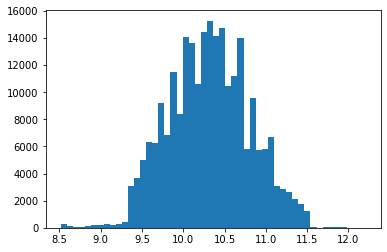

In [12]:
plt.hist(y, bins=50);

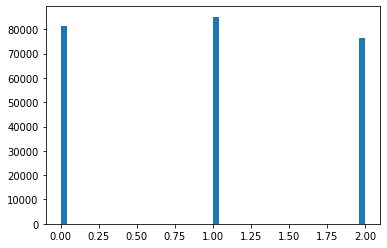

In [13]:
plt.hist(y_cat, bins=50);

# Baseline model

In [14]:
job['Salary_Bins'].value_counts(normalize=True)

1    0.350637
0    0.334150
2    0.315213
Name: Salary_Bins, dtype: float64

# Train test split

In [15]:
import dask.dataframe as dd

In [16]:
#data set is too huge which causes memory error. need to do sampling test
# using a function so we can track memory usage
def dask_read_and_sample(df_train,blocksize, sample_size):
    
    # let us stratify to get the same number of rows for frauds and non-frauds
    sample_2 = df_train.query('Salary_Bins == 2').sample(frac=sample_size)
    sample_1 = df_train.query('Salary_Bins == 1').sample(frac=sample_size)
    sample_0 = df_train.query('Salary_Bins == 0').sample(frac=sample_size)
    
    # concatenate the dataframe
    df_sampled = dd.concat([sample_2, sample_1, sample_0])
    
    return df_sampled.compute(scheduler='synchronous')

# executing
df_train = dask_read_and_sample(job,blocksize=10e10, sample_size=0.005)

In [17]:
df_train.shape

(1215, 13)

In [18]:
X_s1 = df_train['requirements_lem']
y_s1 = df_train['log_avg_salary']
y_cats1=df_train['Salary_Bins'].astype('category')

In [19]:
# Split our data into train and test data. We will stratify during the split to ensure that the train and test sets 
# contains the same percentage of samplesto avoid imbalanced classes.
X_train_s1,X_test_s1,y_train_s1,y_test_s1 = train_test_split(X_s1,y_s1,
                                                 random_state=42, test_size=0.25) # account for slight class unbalanced 

# Simple Feature Modelling

In [20]:
# Vectorizer and Model imports:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LinearRegression,SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier, RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier, AdaBoostClassifier, AdaBoostRegressor,VotingClassifier, VotingRegressor
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_roc_curve, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
job.columns

Index(['LocationNormalized', 'ContractType', 'log_avg_salary',
       'len_requirement', 'words_requirement', 'Salary_Bins',
       'job_title_simp2', 'short_title', 'Category', 'LocationNormalized.1',
       'ContractType.1', 'requirements_lem', 'Salary_Bins_binary'],
      dtype='object')

In [22]:
#X_base=job.drop(columns=['requirements_lem','avg_salary', 'log_avg_salary','Salary_Bins'])
col_base=['job_title_simp2','short_title','LocationNormalized.1',
       'ContractType.1']
X_base=job[col_base]
y_base=job['Salary_Bins']

In [23]:
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_base,y_base,
                                                 random_state=42, test_size=0.25) # account for slight class unbalanced 

In [24]:
# Function to run model -- input vectorizer and model
def model_run_classification_base(mod, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (mod, models_c[mod])
            ])

    if grid_search:
   
        gs = GridSearchCV(pipe, param_grid = {**mod_params}, verbose=3, n_jobs=-1)
        gs.fit(X_train_b, y_train_b)
        pipe = gs
      
    else:
        pipe.fit(X_train_b, y_train_b)

    # Retrieve metrics
    results['model'] = mod
    results['train'] = pipe.score(X_train_b, y_train_b)
    results['test'] = pipe.score(X_test_b, y_test_b)
    predictions = pipe.predict(X_test_b)
    results['MSE'] = mean_squared_error(y_test_b, predictions,squared=False)
    results['MAE'] = mean_absolute_error(y_test_b,predictions)
    results['accuracy']=accuracy_score(y_test_b, predictions)
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list_c_b.append(results)
    # Generate confusion matrix.
    class_names = ["0-100K","100K-130K","130K-271K"]
    cm = confusion_matrix(y_test_b, predictions)  # True vs Predicted values.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'font.size': 16})
    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    disp.plot(ax=ax);
    print('### METRICS ###')
    display(results)
    return pipe

In [25]:
# Instiantiate classification models
models_c = {'knn': KNeighborsClassifier(n_neighbors=3),
          'rfc': RandomForestClassifier(random_state=42),
          'gbc': GradientBoostingClassifier(random_state=42),
          'etc': ExtraTreesClassifier(random_state=42),
          'adac': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42),
            'sgd': SGDClassifier(random_state=42)}

In [26]:
eval_list_c_b=[]

### METRICS ###


{'model': 'knn',
 'train': 0.46589786374514236,
 'test': 0.44001317306109006,
 'MSE': 1.0230667470461425,
 'MAE': 0.7222130742631319,
 'accuracy': 0.44001317306109006}

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=3))])

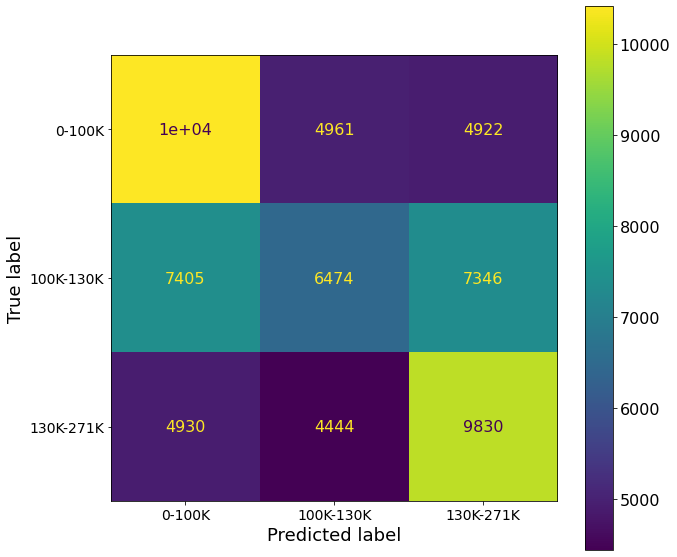

In [27]:
model_run_classification_base('knn')

In [28]:
pd.DataFrame(eval_list_c_b)

model     train      test       MSE       MAE  accuracy
0   knn  0.465898  0.440013  1.023067  0.722213  0.440013

# NLP Modelling

In [29]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# creating my own custom stopwords
custom_stopwords=['\n']

In [30]:
#adding the english stopwords to my custom stopwords+
custom_stopwords.extend(ENGLISH_STOP_WORDS)

In [31]:
cv = CountVectorizer(stop_words=custom_stopwords)
tvec = TfidfVectorizer(stop_words=custom_stopwords)

In [32]:
# Instantiate vectorizers
vectorizers = {'cvec': cv,
               'tvec': tvec}

In [33]:
# Instiantiate regression models
models = {'lr': LinearRegression(),
          'rf': RandomForestRegressor(random_state=42),
          'gb': GradientBoostingRegressor(random_state=42),
          'et': ExtraTreesRegressor(random_state=42),
          'ada': AdaBoostRegressor(random_state=42),
          'svr': SVR()}

In [34]:
# Instiantiate classification models
models_c = {'knn': KNeighborsClassifier(n_neighbors=3),
          'rfc': RandomForestClassifier(random_state=42),
          'gbc': GradientBoostingClassifier(random_state=42),
          'etc': ExtraTreesClassifier(random_state=42),
          'adac': AdaBoostClassifier(random_state=42),
          'svc': SVC(),
           'sgd': SGDClassifier(random_state=42)}

In [35]:
# Function to run model -- input vectorizer and model
def model_run(vec_name,vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (mod, models[mod])
            ])
    X_train_vec =vec.fit_transform(X_train_s1)
    X_test_vec =vec.transform(X_test_s1)
    X_train_df=pd.DataFrame(X_train_vec.todense(),columns=vec.get_feature_names())
    X_test_df=pd.DataFrame(X_test_vec.todense(),columns=vec.get_feature_names())
    if grid_search:
   
        gs = GridSearchCV(vec,pipe, param_grid = {**vec_params, **mod_params}, verbose=3, n_jobs=-1)
        gs.fit(X_train_df, y_train_s1)
        pipe = gs
      
    else:
        pipe.fit(X_train_df, y_train_s1)

    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec_name
    results['train'] = pipe.score(X_train_df, y_train_s1)
    results['test'] = pipe.score(X_test_df, y_test_s1)
    predictions = pipe.predict(X_test_df)
    results['MSE'] = mean_squared_error(y_test_s1, predictions,squared=False)
    results['MAE'] = mean_absolute_error(y_test_s1,predictions)
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list.append(results)
    
    print('### METRICS ###')
    display(results)
    return pipe

In [36]:
from sklearn.metrics import mean_squared_error

# Model testing with TVEC and CVEC

In [37]:
# Create list to store model testing results
eval_list = []

In [38]:
model_run('cvec',cv, 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': -1.5214704585572414,
 'MSE': 0.7570957118467315,
 'MAE': 0.5903404285867355}

Pipeline(steps=[('lr', LinearRegression())])

In [39]:
model_run('tvec',tvec, 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.18802521840144704,
 'MSE': 0.42963050974300837,
 'MAE': 0.34941621209374546}

Pipeline(steps=[('lr', LinearRegression())])

In [40]:
model_run('cvec',cv, 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'train': 0.9095398764813313,
 'test': 0.37034710481754185,
 'MSE': 0.3783331936809771,
 'MAE': 0.2976987799813735}

Pipeline(steps=[('rf', RandomForestRegressor(random_state=42))])

In [41]:
model_run('tvec',tvec, 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 0.9104125644275971,
 'test': 0.38084049234623063,
 'MSE': 0.37516742054320484,
 'MAE': 0.2929893316443929}

Pipeline(steps=[('rf', RandomForestRegressor(random_state=42))])

In [42]:
model_run('cvec',cv, 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'cvec',
 'train': 0.6921750384584768,
 'test': 0.3840092013091737,
 'MSE': 0.3742061809505482,
 'MAE': 0.29493616893778907}

Pipeline(steps=[('gb', GradientBoostingRegressor(random_state=42))])

In [43]:
model_run('tvec',cv, 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'tvec',
 'train': 0.6921750384584768,
 'test': 0.3840092013091737,
 'MSE': 0.3742061809505482,
 'MAE': 0.29493616893778907}

Pipeline(steps=[('gb', GradientBoostingRegressor(random_state=42))])

In [44]:
model_run('cvec',cv, 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.3616706246598068,
 'MSE': 0.3809309497951686,
 'MAE': 0.3018569181814136}

Pipeline(steps=[('et', ExtraTreesRegressor(random_state=42))])

In [45]:
model_run('tvec',cv, 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.3616706246598068,
 'MSE': 0.3809309497951686,
 'MAE': 0.3018569181814136}

Pipeline(steps=[('et', ExtraTreesRegressor(random_state=42))])

In [46]:
model_run('cvec',cv, 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'cvec',
 'train': 0.3013415582906962,
 'test': 0.2037184523676251,
 'MSE': 0.42545846621836986,
 'MAE': 0.33826267457619713}

Pipeline(steps=[('ada', AdaBoostRegressor(random_state=42))])

In [47]:
model_run('tvec',cv, 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'tvec',
 'train': 0.3013415582906962,
 'test': 0.2037184523676251,
 'MSE': 0.42545846621836986,
 'MAE': 0.33826267457619713}

Pipeline(steps=[('ada', AdaBoostRegressor(random_state=42))])

In [48]:
model_run('cvec',cv, 'svr')

### METRICS ###


{'model': 'svr',
 'vectorizer': 'cvec',
 'train': 0.8802483853946353,
 'test': 0.4237231452770226,
 'MSE': 0.36194237578880695,
 'MAE': 0.2827088626125958}

Pipeline(steps=[('svr', SVR())])

In [49]:
model_run('tvec',cv, 'svr')

### METRICS ###


{'model': 'svr',
 'vectorizer': 'tvec',
 'train': 0.8802483853946353,
 'test': 0.4237231452770226,
 'MSE': 0.36194237578880695,
 'MAE': 0.2827088626125958}

Pipeline(steps=[('svr', SVR())])

In [50]:
pd.DataFrame(eval_list)

model vectorizer     train      test       MSE       MAE
0     lr       cvec  1.000000 -1.521470  0.757096  0.590340
1     lr       tvec  1.000000  0.188025  0.429631  0.349416
2     rf       cvec  0.909540  0.370347  0.378333  0.297699
3     rf       tvec  0.910413  0.380840  0.375167  0.292989
4     gb       cvec  0.692175  0.384009  0.374206  0.294936
5     gb       tvec  0.692175  0.384009  0.374206  0.294936
6     et       cvec  1.000000  0.361671  0.380931  0.301857
7     et       tvec  1.000000  0.361671  0.380931  0.301857
8    ada       cvec  0.301342  0.203718  0.425458  0.338263
9    ada       tvec  0.301342  0.203718  0.425458  0.338263
10   svr       cvec  0.880248  0.423723  0.361942  0.282709
11   svr       tvec  0.880248  0.423723  0.361942  0.282709

The best model is random forest model with cvec vectorizer. In this case i think the model is still overfit but its comparatively better than the other models.

## Classification

In [51]:
# Split our data into train and test data. We will stratify during the split to ensure that the train and test sets 
# contains the same percentage of samplesto avoid imbalanced classes.
X_train_cat,X_test_cat,y_train_cat,y_test_cat = train_test_split(X_s1,y_cats1,
                                                 random_state=42, test_size=0.25) # account for slight class unbalanced 

In [52]:
# Function to run model -- input vectorizer and model
def model_run_classification(vec_name,vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (mod, models_c[mod])
            ])
    X_train_vec =vec.fit_transform(X_train_cat)
    X_test_vec =vec.transform(X_test_cat)
    X_train_df=pd.DataFrame(X_train_vec.todense(),columns=vec.get_feature_names())
    X_test_df=pd.DataFrame(X_test_vec.todense(),columns=vec.get_feature_names())
    if grid_search:
   
        gs = GridSearchCV(vec,pipe, param_grid = {**vec_params, **mod_params}, verbose=3, n_jobs=-1)
        gs.fit(X_train_df, y_train_cat)
        pipe = gs
      
    else:
        pipe.fit(X_train_df, y_train_cat)

    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec_name
    results['train'] = pipe.score(X_train_df, y_train_cat)
    results['test'] = pipe.score(X_test_df, y_test_cat)
    predictions = pipe.predict(X_test_df)
    results['MSE'] = mean_squared_error(y_test_cat, predictions,squared=False)
    results['MAE'] = mean_absolute_error(y_test_cat,predictions)
    results['accuracy']=accuracy_score(y_test_cat, predictions)
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list_c.append(results)
    # Generate confusion matrix.
    class_names = ["0-100K","100K-130K","130K-271"]
    cm = confusion_matrix(y_test_cat, predictions)  # True vs Predicted values.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'font.size': 16})
    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    disp.plot(ax=ax);
    print('### METRICS ###')
    display(results)
    return pipe

In [53]:
eval_list_c=[]

### METRICS ###


{'model': 'knn',
 'vectorizer': 'cvec',
 'train': 0.6948408342480791,
 'test': 0.4440789473684211,
 'MSE': 1.080630907338272,
 'MAE': 0.7598684210526315,
 'accuracy': 0.4440789473684211}

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=3))])

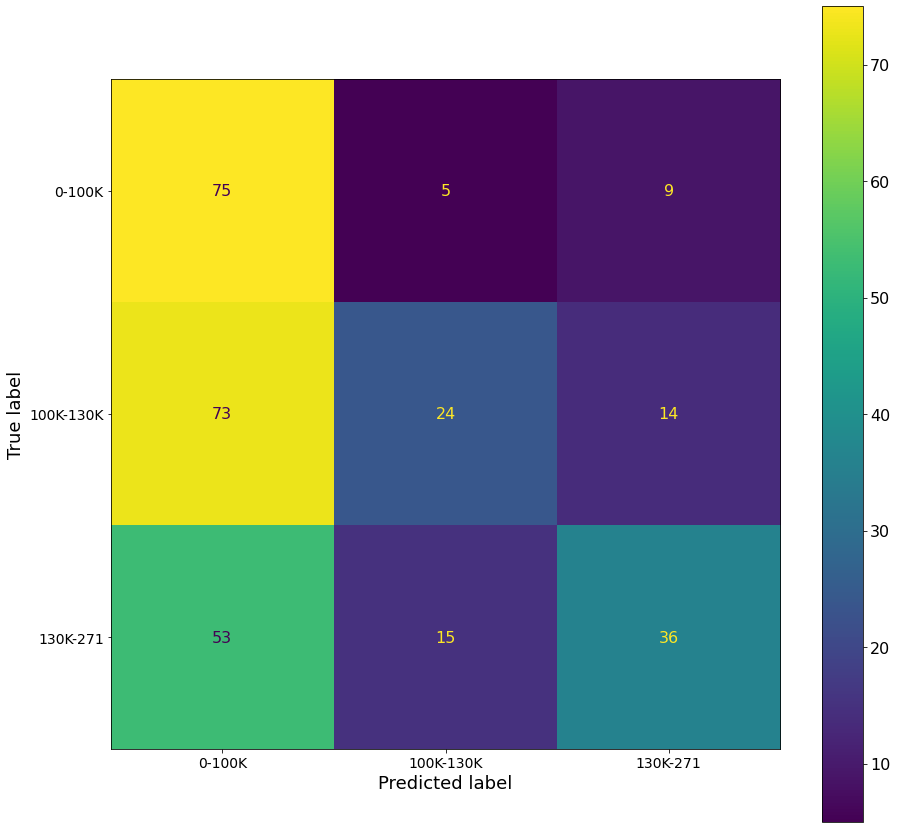

In [54]:
model_run_classification('cvec',cv, 'knn')

### METRICS ###


{'model': 'knn',
 'vectorizer': 'tvec',
 'train': 0.6948408342480791,
 'test': 0.4440789473684211,
 'MSE': 1.080630907338272,
 'MAE': 0.7598684210526315,
 'accuracy': 0.4440789473684211}

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=3))])

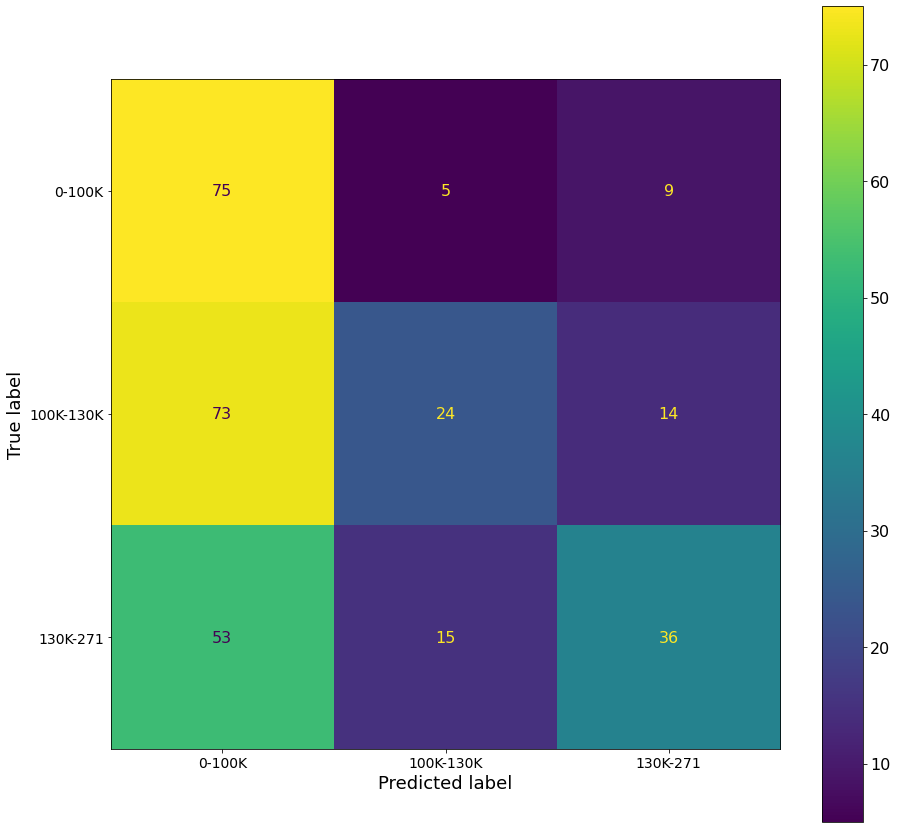

In [55]:
model_run_classification('tvec',cv, 'knn')

### METRICS ###


{'model': 'rfc',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.5723684210526315,
 'MSE': 0.7521897856819185,
 'MAE': 0.47368421052631576,
 'accuracy': 0.5723684210526315}

Pipeline(steps=[('rfc', RandomForestClassifier(random_state=42))])

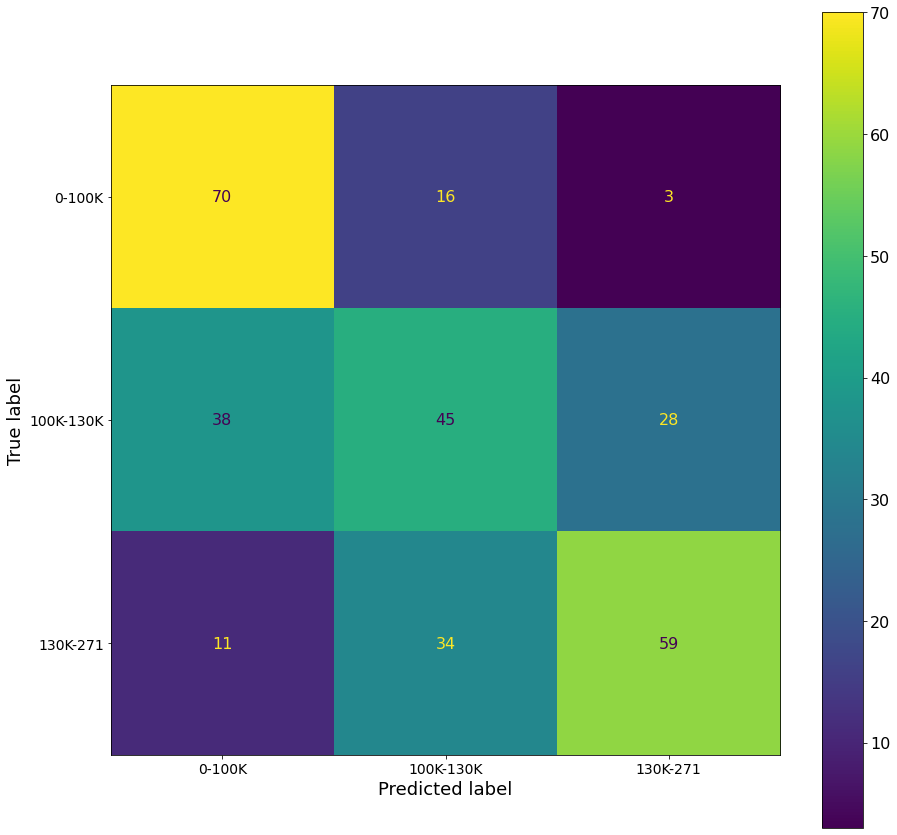

In [56]:
model_run_classification('cvec',cv, 'rfc')

### METRICS ###


{'model': 'rfc',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.5723684210526315,
 'MSE': 0.7521897856819185,
 'MAE': 0.47368421052631576,
 'accuracy': 0.5723684210526315}

Pipeline(steps=[('rfc', RandomForestClassifier(random_state=42))])

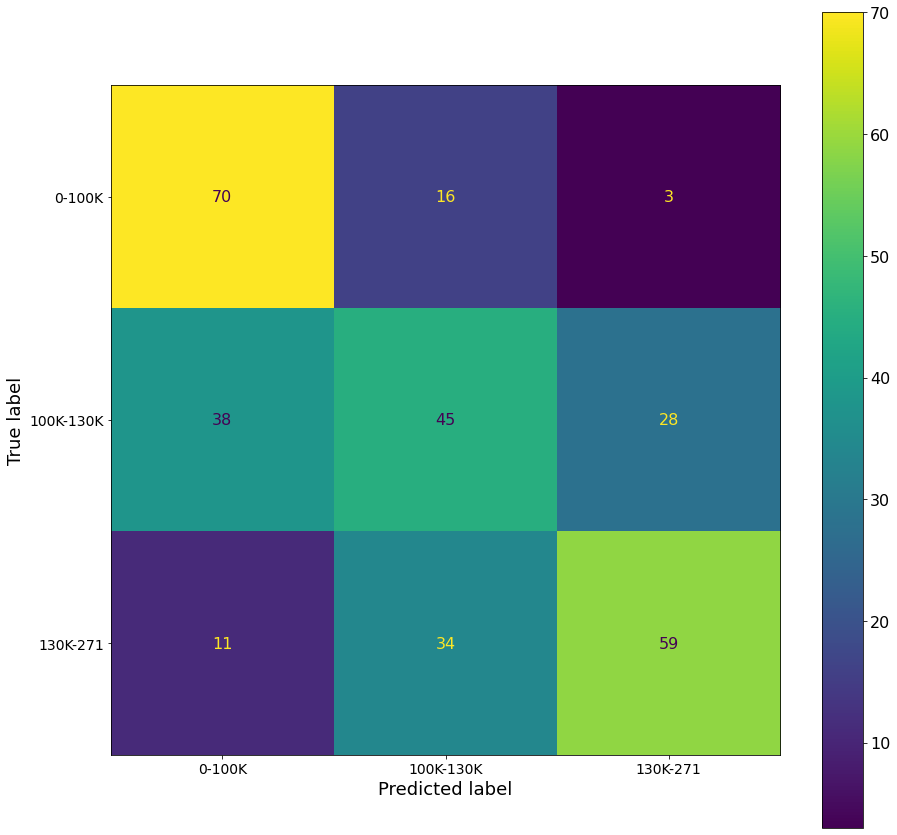

In [57]:
model_run_classification('tvec',cv, 'rfc')

### METRICS ###


{'model': 'gbc',
 'vectorizer': 'cvec',
 'train': 0.9462129527991219,
 'test': 0.5526315789473685,
 'MSE': 0.784303244254012,
 'MAE': 0.5032894736842105,
 'accuracy': 0.5526315789473685}

Pipeline(steps=[('gbc', GradientBoostingClassifier(random_state=42))])

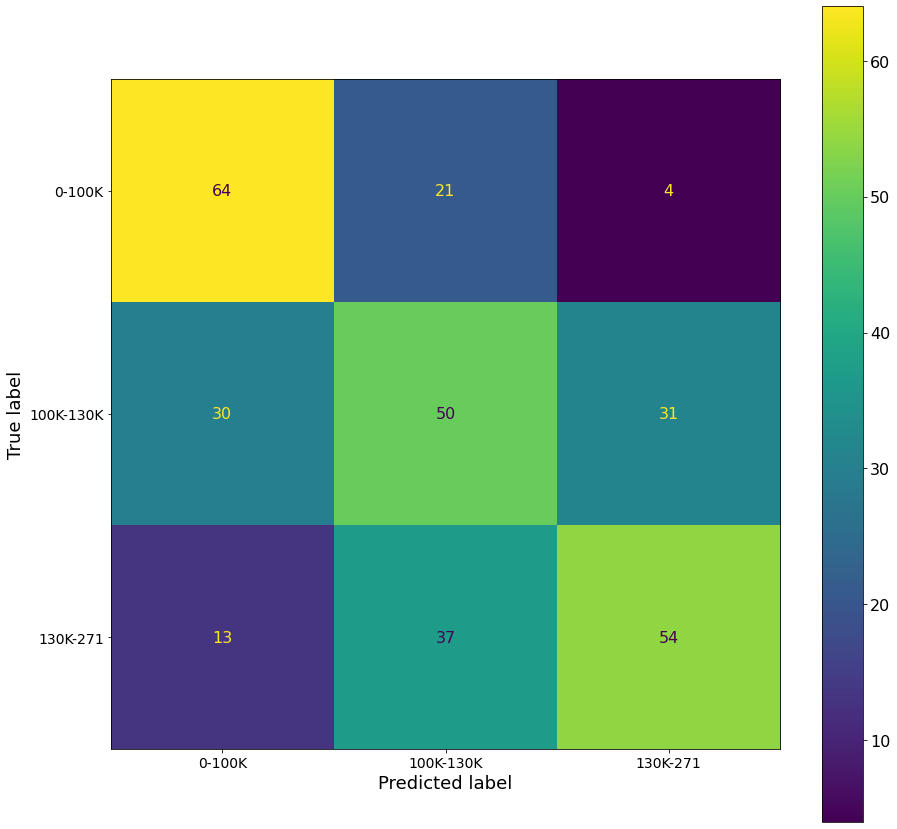

In [58]:
model_run_classification('cvec',cv, 'gbc')

### METRICS ###


{'model': 'gbc',
 'vectorizer': 'tvec',
 'train': 0.9462129527991219,
 'test': 0.5526315789473685,
 'MSE': 0.784303244254012,
 'MAE': 0.5032894736842105,
 'accuracy': 0.5526315789473685}

Pipeline(steps=[('gbc', GradientBoostingClassifier(random_state=42))])

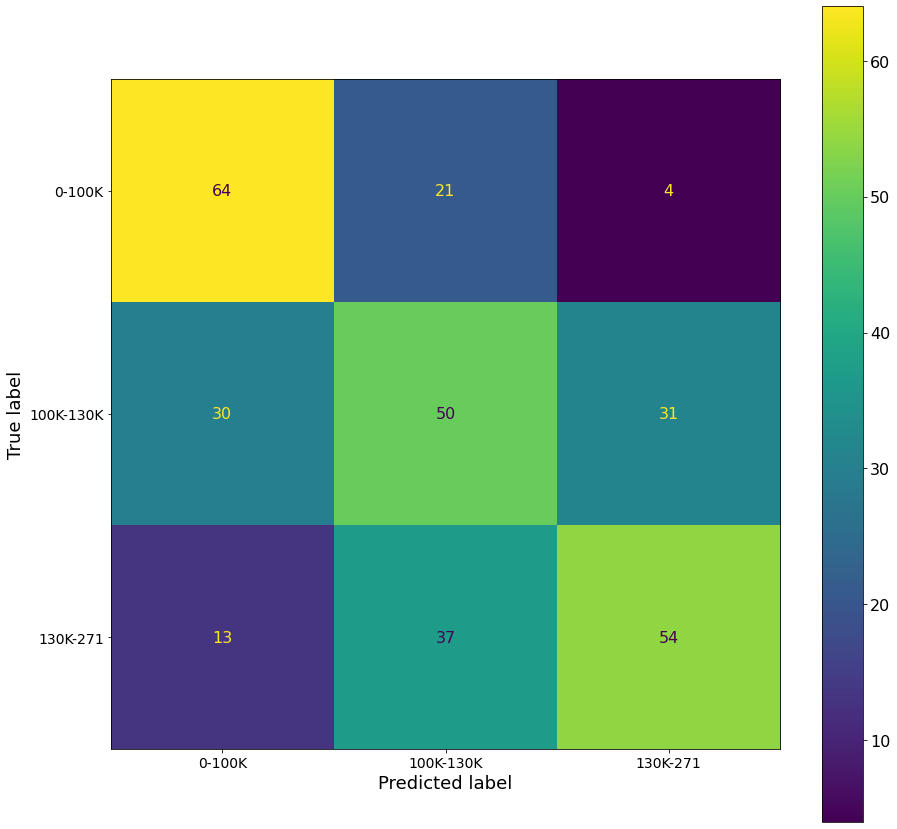

In [59]:
model_run_classification('tvec',cv, 'gbc')

### METRICS ###


{'model': 'etc',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.6052631578947368,
 'MSE': 0.7565503427086868,
 'MAE': 0.45394736842105265,
 'accuracy': 0.6052631578947368}

Pipeline(steps=[('etc', ExtraTreesClassifier(random_state=42))])

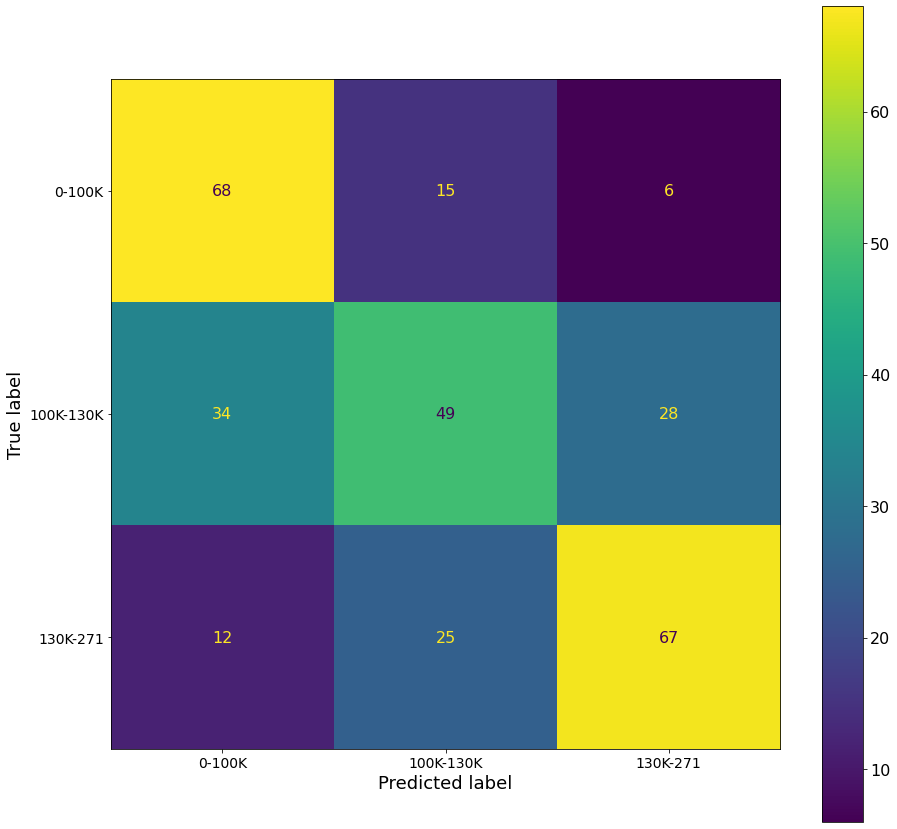

In [60]:
model_run_classification('cvec',cv, 'etc')

### METRICS ###


{'model': 'etc',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.6052631578947368,
 'MSE': 0.7565503427086868,
 'MAE': 0.45394736842105265,
 'accuracy': 0.6052631578947368}

Pipeline(steps=[('etc', ExtraTreesClassifier(random_state=42))])

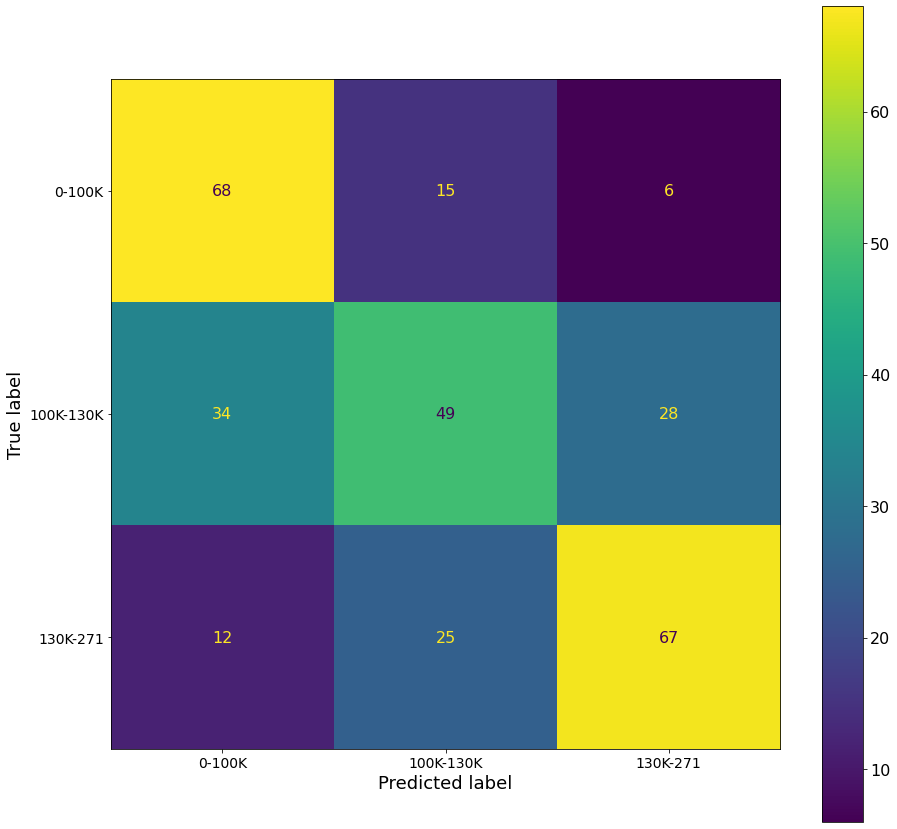

In [61]:
model_run_classification('tvec',cv, 'etc')

### METRICS ###


{'model': 'adac',
 'vectorizer': 'tvec',
 'train': 0.6564215148188803,
 'test': 0.5263157894736842,
 'MSE': 0.7884862245567702,
 'MAE': 0.5230263157894737,
 'accuracy': 0.5263157894736842}

Pipeline(steps=[('adac', AdaBoostClassifier(random_state=42))])

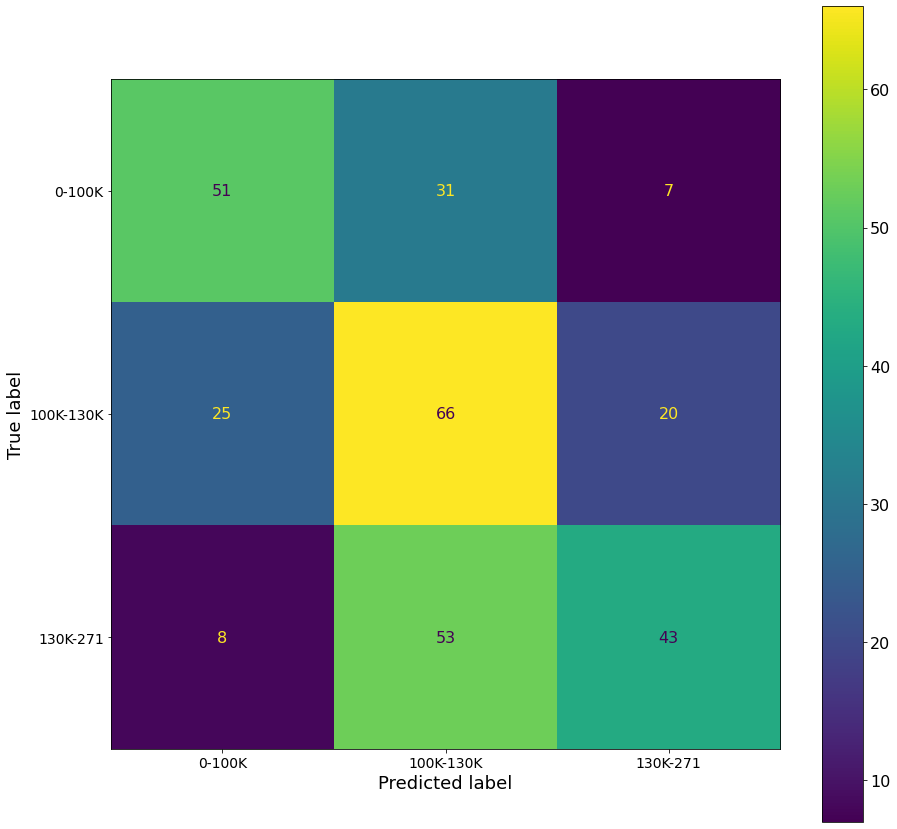

In [62]:
model_run_classification('tvec',cv, 'adac')

### METRICS ###


{'model': 'adac',
 'vectorizer': 'cvec',
 'train': 0.6564215148188803,
 'test': 0.5263157894736842,
 'MSE': 0.7884862245567702,
 'MAE': 0.5230263157894737,
 'accuracy': 0.5263157894736842}

Pipeline(steps=[('adac', AdaBoostClassifier(random_state=42))])

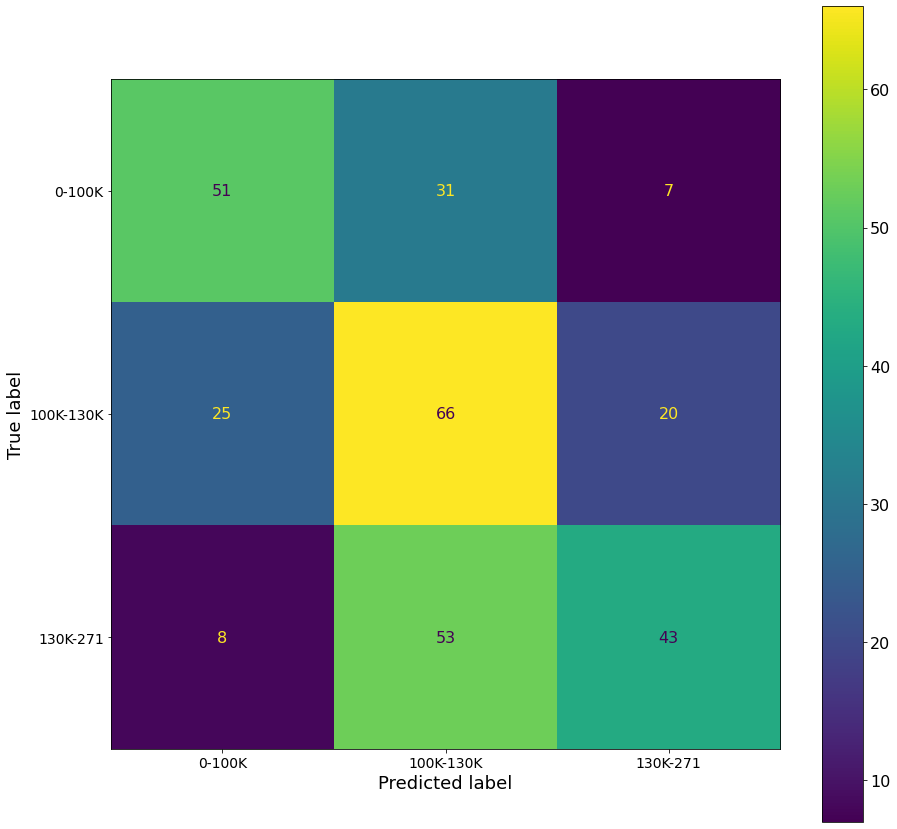

In [63]:
model_run_classification('cvec',cv, 'adac')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.897914379802415,
 'test': 0.5888157894736842,
 'MSE': 0.7543732149065349,
 'MAE': 0.46381578947368424,
 'accuracy': 0.5888157894736842}

Pipeline(steps=[('svc', SVC())])

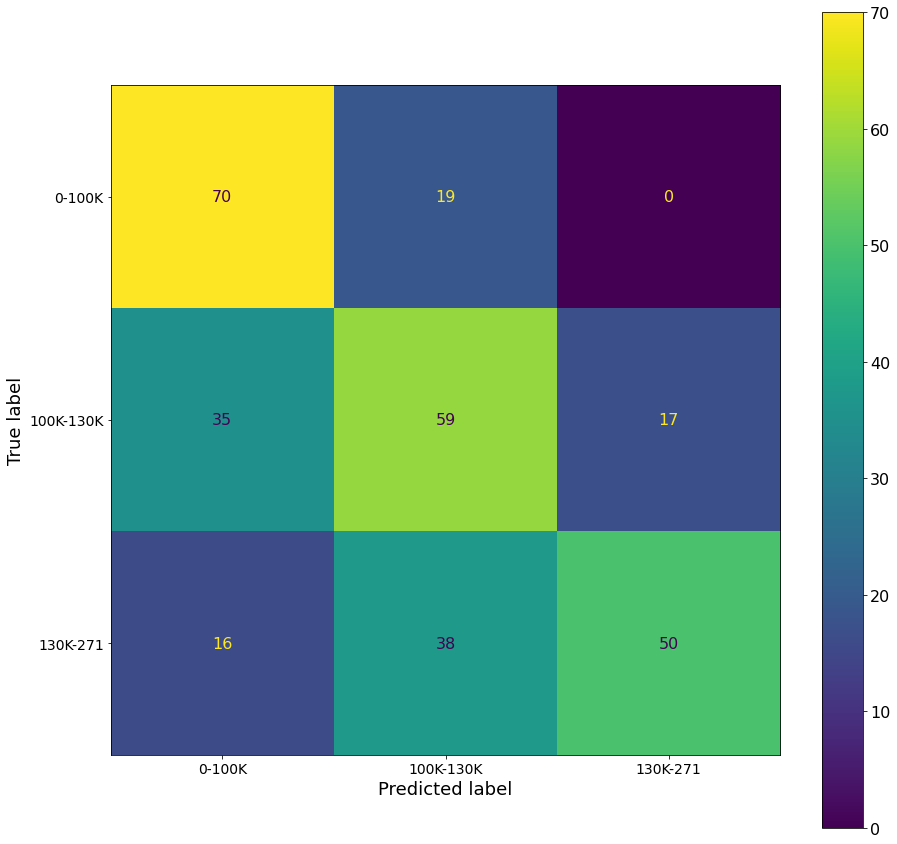

In [64]:
model_run_classification('tvec',cv, 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'train': 0.897914379802415,
 'test': 0.5888157894736842,
 'MSE': 0.7543732149065349,
 'MAE': 0.46381578947368424,
 'accuracy': 0.5888157894736842}

Pipeline(steps=[('svc', SVC())])

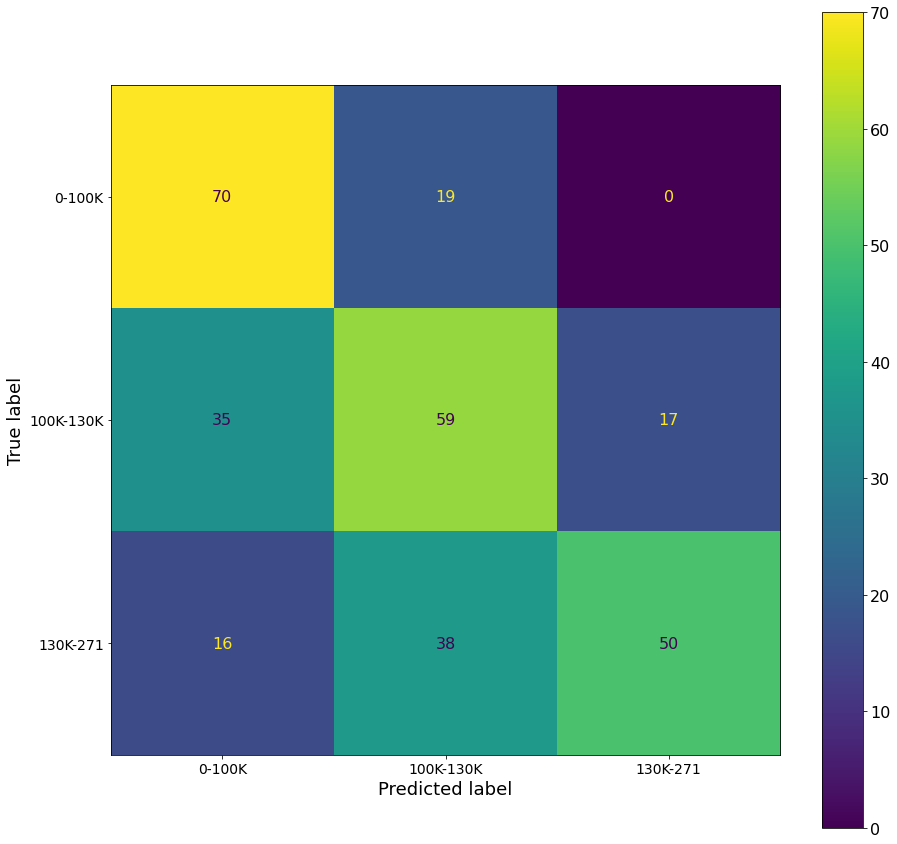

In [65]:
model_run_classification('cvec',cv, 'svc')

In [66]:
pd.DataFrame(eval_list_c)

model vectorizer     train      test       MSE       MAE  accuracy
0    knn       cvec  0.694841  0.444079  1.080631  0.759868  0.444079
1    knn       tvec  0.694841  0.444079  1.080631  0.759868  0.444079
2    rfc       cvec  1.000000  0.572368  0.752190  0.473684  0.572368
3    rfc       tvec  1.000000  0.572368  0.752190  0.473684  0.572368
4    gbc       cvec  0.946213  0.552632  0.784303  0.503289  0.552632
5    gbc       tvec  0.946213  0.552632  0.784303  0.503289  0.552632
6    etc       cvec  1.000000  0.605263  0.756550  0.453947  0.605263
7    etc       tvec  1.000000  0.605263  0.756550  0.453947  0.605263
8   adac       tvec  0.656422  0.526316  0.788486  0.523026  0.526316
9   adac       cvec  0.656422  0.526316  0.788486  0.523026  0.526316
10   svc       tvec  0.897914  0.588816  0.754373  0.463816  0.588816
11   svc       cvec  0.897914  0.588816  0.754373  0.463816  0.588816

# SVC with Gridsearch

In [67]:
ExtraTreesClassifier().get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
param_grid = {'C': [1.0,2.0],
              'degree': [3,8],
              'class_weight': [None, 'balanced']}

### METRICS ###


{'model': 'etc',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.6052631578947368,
 'MSE': 0.7565503427086868,
 'MAE': 0.45394736842105265,
 'accuracy': 0.6052631578947368}

Pipeline(steps=[('etc', ExtraTreesClassifier(random_state=42))])

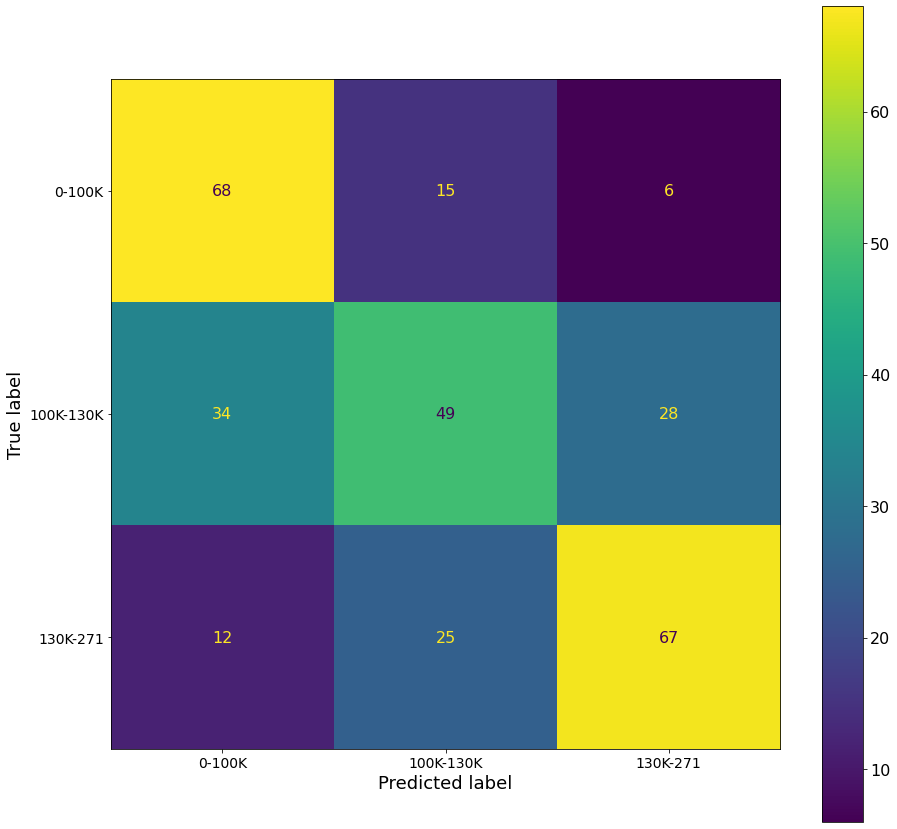

In [69]:
model_run_classification('cvec',cv, 'etc',mod_params=param_grid)

In [70]:
#Best model is the cvec and the Extra trees classifier model with default hyperparameter. We will export it to apply in the flask api.

## Modifying weights to misclassified words

In [71]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

In [72]:
cvec=CountVectorizer(stop_words=custom_stopwords)

In [73]:
X_train_cvec =cvec.fit_transform(X_train_cat)
X_test_cvec = cvec.transform(X_test_cat)

In [74]:
import pickle
# Saving tvec model to disk
pickle.dump(cvec, open('cvec.pkl','wb'))

In [75]:
X_train_cvec

<911x8851 sparse matrix of type '<class 'numpy.int64'>'
	with 91055 stored elements in Compressed Sparse Row format>

In [76]:
X_test_cvec

<304x8851 sparse matrix of type '<class 'numpy.int64'>'
	with 29672 stored elements in Compressed Sparse Row format>

In [116]:
X_train_df=pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names())
X_test_df=pd.DataFrame(X_test_cvec.todense(),columns=cvec.get_feature_names())

In [117]:
etc=ExtraTreesClassifier(random_state=42)

In [118]:
etc.fit(X_train_df,y_train_cat)

ExtraTreesClassifier(random_state=42)

In [119]:
etc_preds=etc.predict(X_test_df)

In [120]:
etc.score(X_train_df,y_train_cat)

1.0

In [121]:
etc.score(X_test_df,y_test_cat)

0.6052631578947368

In [83]:
df_etc_check=pd.DataFrame({'description':X_test_cat,
                          'true labels':y_test_cat,
                          'predicted':etc_preds})

In [84]:
pd.set_option ('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [114]:
#checking misclassified groups from bin=2 
df_etc_check[(df_etc_check['true labels']!=df_etc_check['predicted']) & (df_etc_check['true labels']==1)][:8]

description  \
234413                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Salary Upto pound annum plus bonus Location Bristol Company nbspCherryred Recruitment Job Title Restaurant Management Job Description We currently recruit Head Chef position number key clients UK register vacancies choose Cherryred consultancy choice Are Head Chef want develop career know expand group Are Head Chef prefer work independent business excellent local reputation want raise profile Are Head Chef just want work company dedicate time train develop career Are experience Head Chef just ready change If answer yes question love hear Please apply consultants shortly confidentially discuss career goals Cherryred true specialist consultancy business specialise Hospitality Catering Managerial roles house We believe advice give sense pride Advice specific individuals majority To Cherryred sentence ldquoWe focus professional drive excite funky cool passionate rdquo PLEASE APPLY NOW nbsp PLEASE ONLY APPLY IF YOU LIVE WITHIN EASY COMMUTE OF THIS JOB   
62497                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

missing some keywords like executive,business,lead,IT... 

In [89]:
#Check and Add weights
#print(cvec.vocabulary_)

In [91]:
weight=10

In [115]:
#X_train_cvec[:,cvec.vocabulary_['lead']]*=weight
#X_train_cvec[:,cvec.vocabulary_['executive']]*=weight
#X_train_cvec[:,cvec.vocabulary_['finance']]*=weight
#X_train_cvec[:,cvec.vocabulary_['management']]*=weight
#X_train_cvec[:,cvec.vocabulary_['project']]*=weight
#X_train_cvec[:,cvec.vocabulary_['director']]*=weight
#X_train_cvec[:,cvec.vocabulary_['business']]*=weight

# manual weights made the model performed worse or comparable. not recommended.

In [122]:
MSE=mean_squared_error(y_test_cat, etc_preds, squared=False)
MSE

0.763044456178841

In [123]:
fitted_cvdf=cvec.fit(X_train_cat)

In [124]:
cvdf_transformed=fitted_cvdf.transform(X_train_cat)

In [126]:
model_final=etc.fit(cvdf_transformed,y_train_cat)

In [127]:
#Testing if the model to be exported works later in flask api.
description='Position Network Security CCIE CCNP CCDP CCSP Salary k car allowance bonus Location Home base offices allround country Apply Reference The Background Following period sustain growth opportunity arise Network Security Architect join thrive Network division wellknown Consultancy Practice base UK The Network Security Architect responsible provide presales post sales consultancy multiple enterprise scale security engagements drive standards practice They develop Security project stay forefront emergent technologies vendors The Role The successful Network Security Architect involve form consultancy lifecycle project They assist Presales technical requirements attend customer strategy meet ultimately understand technical business requirements customer Responsibilities extend authorise enterprise scale Security Designs develop business case provide SOW documentation handingover project initiation implementation engineer You Must good experience current accreditation Cisco Juniper security solutions Checkpoint Fortinet Symantec RSA knowledge experience accreditation advantage Strong rout switch skills ability design complex technical network solutions Ability design enterprise scale security solutions complex Unified Communications Networking opportunities Cisco presales design delivery experience To work lead technical consultant lead team technical consultants postsales delivery project To work consultancy assignments wide variety organisations Experience work number large organisations IT users Leadership organisational skills ability provide technical leadership mentor Security experience Firewalls VPN Authentication Identity Based Management TrustSec virtual security Vendor experience Cisco Checkpoint Juniper Citrix RSA Symantec Fortinet General experience Routing Switching Load Balancing Application Acceleration Wireless LAN Data Centre Virtualisation Vendor experience Cisco Juniper F HP Brocade Citrix Bluecoat VMWare Must current CCIE Security write Lab If Network Security Architect think role forward uptodate CV call Chris Lear JAM Recruitment Ltd act employment business regard position View latest job today follow Facebook Twitter LinkedIn JAM Recruitment act employment agency regard position This job originally post'

In [128]:
labels=['Below 24400','24400-37500','37500-200000']


#BINS = [0,24400,37500,200000]

In [129]:
a=labels[model_final.predict(fitted_cvdf.transform([description]))[0]]

In [130]:
a

'37500-200000'

In [132]:
etc.feature_importances_

array([6.77653243e-05, 0.00000000e+00, 2.36457664e-05, ...,
       1.82793957e-05, 0.00000000e+00, 4.43194483e-05])

In [134]:
lis = []
for i,j in zip(etc.feature_importances_,X_train_df.columns):
    dic = {}
    dic['coef'] = i
    lis.append(dic)
etc_coef_df=pd.DataFrame(lis).set_index(X_train_df.columns).sort_values('coef',ascending=False)

In [135]:
etc_coef_50=pd.concat([etc_coef_df.tail(50),etc_coef_df.head(50)]).sort_values('coef',ascending=False)
etc_coef_50

coef
hours            0.004843
senior           0.003271
project          0.003055
duties           0.002841
design           0.002683
busy             0.002609
development      0.002578
analysis         0.002576
professionals    0.002544
job              0.002352
engineer         0.002256
previous         0.002188
management       0.002158
week             0.002153
business         0.002152
mechanical       0.002138
salary           0.002032
technical        0.002030
track            0.001988
manage           0.001971
highly           0.001968
london           0.001834
lead             0.001812
experience       0.001797
initiative       0.001786
customer         0.001758
telephone        0.001741
assistant        0.001709
years            0.001699
successful       0.001697
manager          0.001685
look             0.001663
career           0.001638
financial        0.001593
skills           0.001588
qts              0.001552
international    0.001551
base             0.001524
environment      0.001507
attention        0.001506
time             0.001502
application      0.001500
originally       0.001498
query            0.001484
enquiries        0.001465
key              0.001461
adoption         0.001452
manner           0.001450
solutions        0.001449
sector           0.001443
renfrewshire     0.000000
reps             0.000000
requiered        0.000000
requests         0.000000
malmesbury       0.000000
careerin         0.000000
reputations      0.000000
dh               0.000000
manageability    0.000000
manageable       0.000000
manageer         0.000000
manhole          0.000000
reproted         0.000000
pmi              0.000000
caregivers       0.000000
representatives  0.000000
dexterity        0.000000
representation   0.000000
carexcellent     0.000000
repository       0.000000
carlo            0.000000
carmarthenshire  0.000000
marginalise      0.000000
destruction      0.000000
malit            0.000000
reporter         0.000000
manmanager       0.000000
devs             0.000000
mansfield        0.000000
devlopment       0.000000
manually         0.000000
replacement      0.000000
deviation        0.000000
develops         0.000000
deutschland      0.000000
carrier          0.000000
repayment        0.000000
replication      0.000000
determining      0.000000
map              0.000000
mapinfo          0.000000
reorganisations  0.000000
reorder          0.000000
reoccurrence     0.000000
reoccupation     0.000000
detectors        0.000000
marcom           0.000000
detection        0.000000
repairbasic      0.000000
marilyn          0.000000

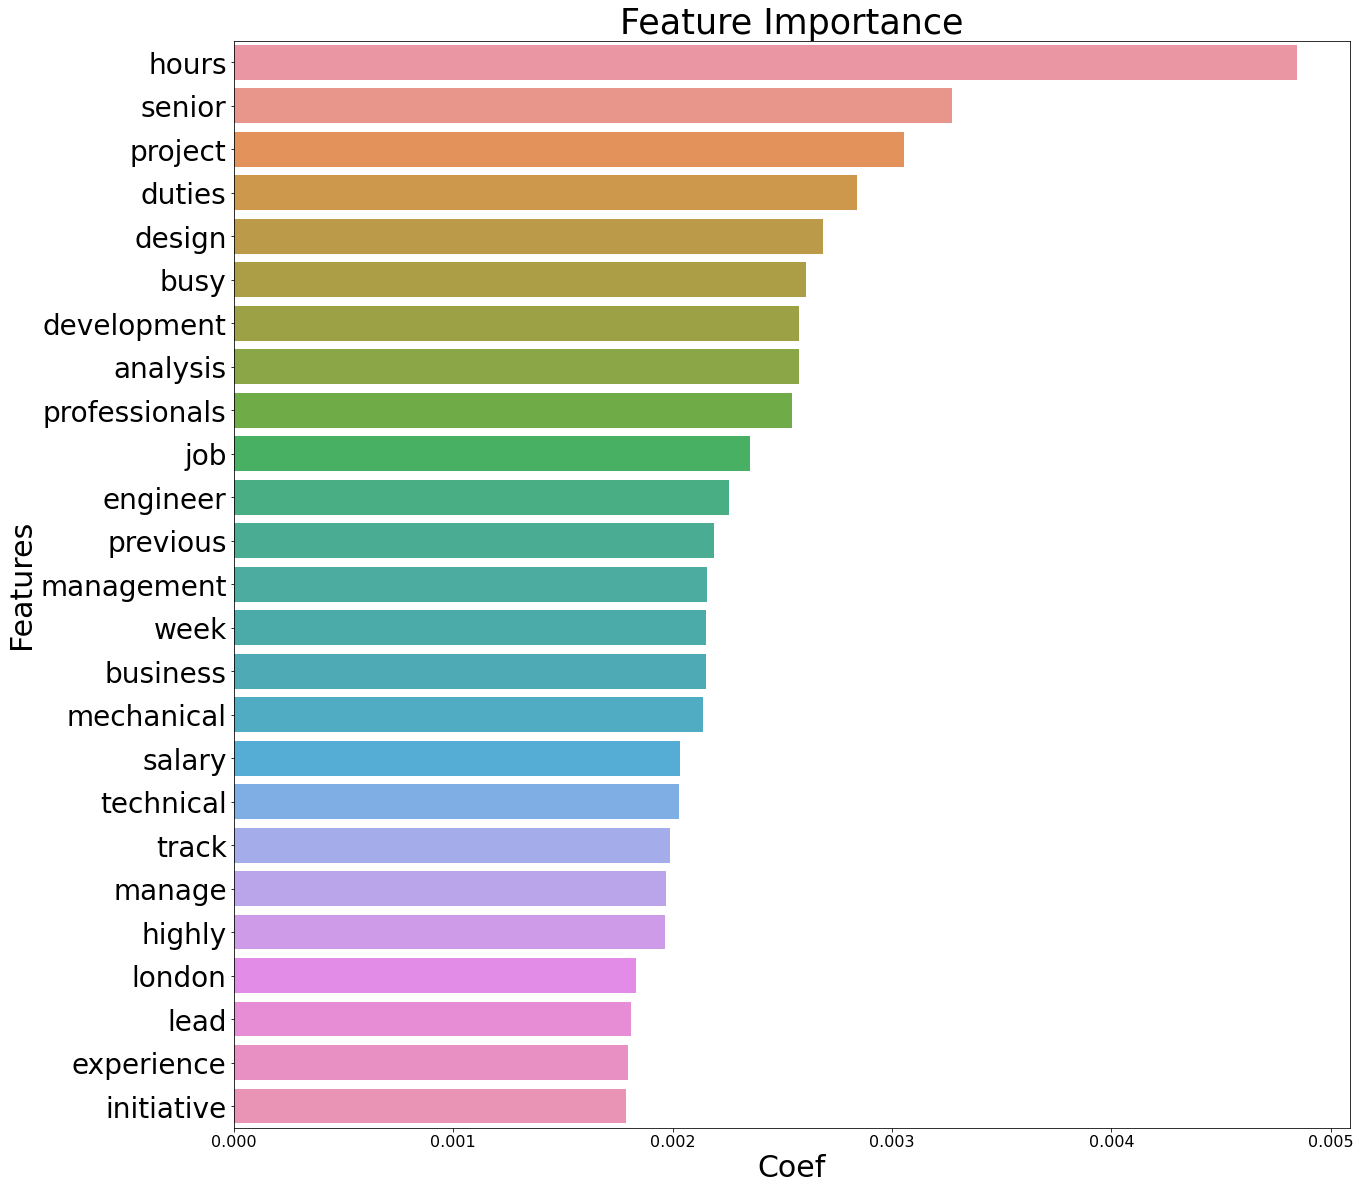

In [152]:
plt.figure(figsize=(20,20))
sns.barplot(etc_coef_50['coef'][:25],etc_coef_50.index[:25]);
plt.title('Feature Importance',size=35)
plt.yticks(size=28)
plt.xlabel('Coef',size=30)
plt.ylabel('Features',size=30);

In [153]:
import pickle
import requests
import json

In [154]:
# Saving tfidf and lr model to disk
pickle.dump(fitted_cvdf, open('fitted_cvdf.pkl','wb'))
pickle.dump(model_final, open('model_final.pkl','wb'))

# Word2Vec

In [155]:
from gensim.models import Word2Vec
import nltk

In [156]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [157]:
X_cleaned=clean_word(X_train_s1)

In [158]:
len(X_train_s1)

911

In [159]:
len(X_cleaned)

911

In [160]:
w2v_model1 = Word2Vec(X_cleaned,
                window=10,
                min_count=4, #min frequency appeared in the corpus
                workers=4)

In [161]:
w2v_model1.train(X_s1,total_examples=w2v_model1.corpus_count, epochs=10)

(3357000, 14107620)

In [162]:

wv = w2v_model1.wv

In [163]:
wv

In [169]:
wv.most_similar('model')

[('methodologies', 0.9995957016944885),
 ('installation', 0.9994273781776428),
 ('repair', 0.999341607093811),
 ('configuration', 0.9993340969085693),
 ('integrate', 0.9992402791976929),
 ('input', 0.9991832971572876),
 ('techniques', 0.9991616010665894),
 ('perform', 0.9990700483322144),
 ('result', 0.9990331530570984),
 ('electronic', 0.9990240931510925)]

In [170]:
#wrap into a dictionary to use in the pipeline
w2v = dict(zip(w2v_model1.wv.index2word, w2v_model1.wv.vectors))

In [171]:
len(w2v.values())

3319

In [172]:
#Averaging word vectors for all words in a text.

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

## Use Word2Vec in the pipeline

In [173]:
#Import libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import time
import nltk
from nltk.corpus import stopwords

#NLP
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Deep learning
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn

#Deep Learning - Mixed inputs
#from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam

#Save Model
import pickle

import matplotlib.pyplot as plt

from pprint import pprint
from time import time
import logging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

from pprint import pprint
from time import time
import logging

In [174]:
#Use pipeline 

rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestRegressor())])

sgd = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
               ('Stochastic Gradient Descent', SGDClassifier(alpha=0.001, n_jobs=3))])

svr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('SVR-lin', SVR())])
                
lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Linear Regression', LinearRegression(n_jobs=3))])

In [175]:
models = [('Random Forest', rf),
          ('Support Vector Regressor', svr),
          ('Linear Regression', lr)]

In [176]:
scores = [(name, cross_val_score(model, X_cleaned, y_train_s1, cv=2).mean()) for name, model, in models]

In [177]:
scores

[('Random Forest', 0.16178556532093596),
 ('Support Vector Regressor', 0.1144269517704134),
 ('Linear Regression', 0.12848054134616754)]

In [178]:
#for word 2 vec, random forest performs the best but still lower than using etc with cvec as shown previously.

# Deep Learning Models with Word Embeddings

In [179]:
from keras_preprocessing import text

In [180]:
from keras_preprocessing.sequence import pad_sequences

In [181]:
from keras.utils import np_utils

In [182]:
tokenizer = text.Tokenizer()
tokenizer.num_words = 500  #limit the number of words to keep most common 1000 words
tokenizer.fit_on_texts(list(df_train['requirements_lem']))
list_tokenized_jd = tokenizer.texts_to_sequences(df_train['requirements_lem'])

X_t = pad_sequences(list_tokenized_jd, maxlen=400, padding = 'post') 

In [183]:
#Encoding to categorical classes
y_cat_dl = to_categorical(y_cats1.values, num_classes=6, dtype="float32")

In [184]:
y_cat_dl

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [185]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_t, y_cat_dl, test_size=0.2, random_state=4)

# Create Base Model

In [186]:
model = Sequential()

embedding_size = 72  #each word onto a 32 length real valued vector
model.add(Embedding(input_dim = 1000, output_dim = embedding_size, input_length = 400)) #try 100, 200, single LSTM and single dense 100
model.add(LSTM(100))
#model.add(LSTM(64))
#model.add(GlobalMaxPool1D())
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(6, activation='softmax'))

In [187]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 72)           72000     
                                                                 
 lstm (LSTM)                 (None, 100)               69200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 142,918
Trainable params: 142,918
Non-trai

In [188]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [189]:
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=[X_test, y_test])

Epoch 1/20
20/20 [==============================] - 11s 443ms/step - loss: 1.4527 - accuracy: 0.3447 - val_loss: 1.1658 - val_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 9s 470ms/step - loss: 1.1992 - accuracy: 0.3282 - val_loss: 1.1239 - val_accuracy: 0.3210
Epoch 3/20
20/20 [==============================] - 10s 495ms/step - loss: 1.1491 - accuracy: 0.3251 - val_loss: 1.1185 - val_accuracy: 0.3457
Epoch 4/20
20/20 [==============================] - 9s 448ms/step - loss: 1.1424 - accuracy: 0.3158 - val_loss: 1.1140 - val_accuracy: 0.3210
Epoch 5/20
20/20 [==============================] - 9s 428ms/step - loss: 1.1327 - accuracy: 0.3200 - val_loss: 1.1081 - val_accuracy: 0.3210
Epoch 6/20
20/20 [==============================] - 9s 433ms/step - loss: 1.1287 - accuracy: 0.3138 - val_loss: 1.1118 - val_accuracy: 0.3210
Epoch 7/20
20/20 [==============================] - 9s 431ms/step - loss: 1.1445 - accuracy: 0.3025 - val_loss: 1.1063 - val_accuracy: 0.3457
Epoc

Train: 0.352, Test: 0.346


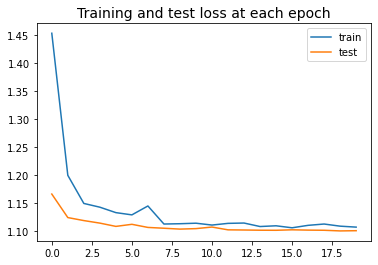

In [190]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and test loss at each epoch', fontsize=14)
plt.legend()
plt.show()

Train: 0.352, Test: 0.346


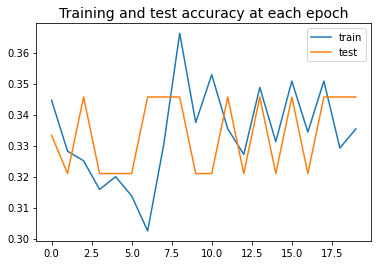

In [191]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Training and test accuracy at each epoch', fontsize=14)
plt.legend()
plt.show()

LSTM model wasnt performing that well compared to ETC with CVEC.

# Using Pycaret for multiple features and NLP modeling

In [ ]:
#!pip install pycaret

In [ ]:
#pip install sklearn

In [193]:
df_train.columns

Index(['LocationNormalized', 'ContractType', 'log_avg_salary',
       'len_requirement', 'words_requirement', 'Salary_Bins',
       'job_title_simp2', 'short_title', 'Category', 'LocationNormalized.1',
       'ContractType.1', 'requirements_lem', 'Salary_Bins_binary'],
      dtype='object')

In [194]:
num_c=['Salary_Bins','job_title_simp2','short_title','LocationNormalized.1',
       'ContractType.1']
df_train[num_c]=df_train[num_c].astype('category')

In [195]:
interest_col=['job_title_simp2','short_title','LocationNormalized.1',
       'ContractType.1','requirements_lem']
X_py=df_train[interest_col]
y_py=df_train['Salary_Bins']

In [196]:
X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(X_py,y_py,
                                                 random_state=42, test_size=0.25) # account for slight class unbalanced 

In [197]:
job_py=pd.concat([X_train_p,y_train_p],axis=1)
job_py_test=pd.concat([X_test_p,y_test_p],axis=1)

In [198]:
job_py

job_title_simp2 short_title LocationNormalized.1 ContractType.1  \
91827              4.0         6.0                154.0            2.0   
86117              3.0         6.0               1488.0            2.0   
105311             6.0         6.0               1410.0            0.0   
27796              4.0         6.0               1488.0            2.0   
5942               3.0         6.0               2448.0            0.0   
61359              3.0         6.0               1820.0            2.0   
135501             3.0         6.0               2448.0            2.0   
137667             4.0         6.0               1029.0            1.0   
15571              3.0         6.0                986.0            0.0   
225015             3.0         6.0               1551.0            2.0   
220112             4.0         7.0               1686.0            2.0   
58283              4.0         6.0               2448.0            2.0   
198479             3.0         6.0               2570.0            2.0   
85092              4.0         6.0               1013.0            2.0   
6036               4.0         6.0               2448.0            1.0   
148736             4.0         6.0               2448.0            2.0   
6750               4.0         6.0                986.0            2.0   
66418              3.0         6.0                994.0            2.0   
159392             4.0         6.0               2155.0            2.0   
82944              6.0         6.0                309.0            2.0   
63901              6.0         6.0               2448.0            2.0   
11786              4.0         6.0                656.0            0.0   
203877             4.0         0.0               1488.0            2.0   
24293              4.0         6.0                904.0            2.0   
241041             4.0         6.0               2155.0            2.0   
154470             4.0         6.0               1488.0            0.0   
161193             4.0         6.0               2448.0            2.0   
95591              3.0         6.0                726.0            0.0   
215359             4.0         5.0               1752.0            2.0   
107212             4.0         6.0               2119.0            2.0   
46976              3.0         6.0               2365.0            0.0   
47247              4.0         7.0               2365.0            0.0   
164557             4.0         6.0               2518.0            2.0   
140496             4.0         6.0               2448.0            2.0   
11373              4.0         6.0               1085.0            0.0   
82626              4.0         6.0               1972.0            2.0   
167044             3.0         6.0               1586.0            0.0   
192151             4.0         6.0               2365.0            2.0   
34936              4.0         6.0                635.0            2.0   
229343             3.0         6.0               1776.0            2.0   
162597             4.0         6.0                726.0            2.0   
99673              3.0         6.0               1776.0            2.0   
100037             3.0         6.0               1817.0            2.0   
206512             4.0         6.0               2377.0            2.0   
232862             4.0         6.0               2448.0            2.0   
206321             4.0         6.0                241.0            2.0   
140189             3.0         6.0               1488.0            0.0   
192936             4.0         6.0               1921.0            0.0   
117095             4.0         2.0               2448.0            2.0   
166300             3.0         6.0               2448.0            2.0   
178920             4.0         6.0               2448.0            2.0   
99942              6.0         6.0               2177.0            2.0   
161875             6.0         6.0               1488.0            2.0   
105128     

In [199]:
job_py.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 91827 to 190185
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   job_title_simp2       911 non-null    category
 1   short_title           911 non-null    category
 2   LocationNormalized.1  911 non-null    category
 3   ContractType.1        911 non-null    category
 4   requirements_lem      911 non-null    object  
 5   Salary_Bins           911 non-null    category
dtypes: category(5), object(1)
memory usage: 31.1+ KB


In [200]:
job.dtypes

LocationNormalized       object
ContractType             object
log_avg_salary          float64
len_requirement           int64
words_requirement         int64
Salary_Bins               int64
job_title_simp2         float64
short_title             float64
Category                float64
LocationNormalized.1    float64
ContractType.1          float64
requirements_lem         object
Salary_Bins_binary        int64
dtype: object

In [201]:
from pycaret.classification import *

In [202]:
exp_mclf1 = setup(data = job_py, target = 'Salary_Bins', session_id=123) 

In [208]:
compare_models()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
#create model
lr = create_model('lr')

In [214]:
#trained model object is stored in the variable 'dt'. 
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [215]:
unseen_predictions = predict_model(lr, data=job_py_test)
unseen_predictions.head()

job_title_simp2 short_title LocationNormalized.1 ContractType.1  \
207696             3.0         6.0               2565.0            2.0   
234413             4.0         6.0                353.0            0.0   
34459              3.0         6.0               2581.0            2.0   
96174              4.0         6.0               2142.0            0.0   
62497              4.0         6.0               2155.0            2.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        requirements_lem  \
207696                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Automotive Motor Trade Job Workshop Manager require West London Salary Basic OTE Per Annum Term Full Time Permanent Motor Trade Jobs Automotive Vacancies Automotive Workshop Manager require West London Our Client LGV LCV service repair centre larger Fleet hire rental business currently look Workshop Manager newly refit Workshop If experience Workshop Controller Main Dealer independent environment ideally commercial vehicle operation perfect opportunity Ideally successful candidate come technical background confident experience motivate staff able provide qual

## Conclusion

In conclusion, count vectorizer with no manual weight tuning is the best model coupled with Extra tress classifier which performs superior in terms of accuracy and MAE (still a multiclass problem with a linear scale). It can better predict the salary based on job descriptions with an accuracy of ~0.6 compared to the base model of 0.35 in a 3 class split probability of predicting it belongs to a 1/3 class.

Deep learning models such as LSTM did not perform that well. The accuracy of the tests shows sinusoidal results which doesnt work on this application.

Pycaret combination of linear features and NLP text features doesnt work as well either. suspect the additional features create noise.

## Recommendation

1. A caveat is that the model was built on the uk dataset in 2013. If there are new data available, the model might not work as well such as during covid theres might be time related influence on the salary and inflation as well.
2. Another problem with this model is that it doesnt take into account of geographical influence, education level and also citizenship because theres no data found.

## Reference

1. https://medium.com/ml2vec/training-and-tuning-a-lstm-to-classify-yelp-reviews-4d37b8aa2e91
2. https://ghanatalksbusiness.com/wp-content/uploads/2017/04/Salary-negotiation-2.jpg